In [29]:
from rl import markov_process, distribution

In [30]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

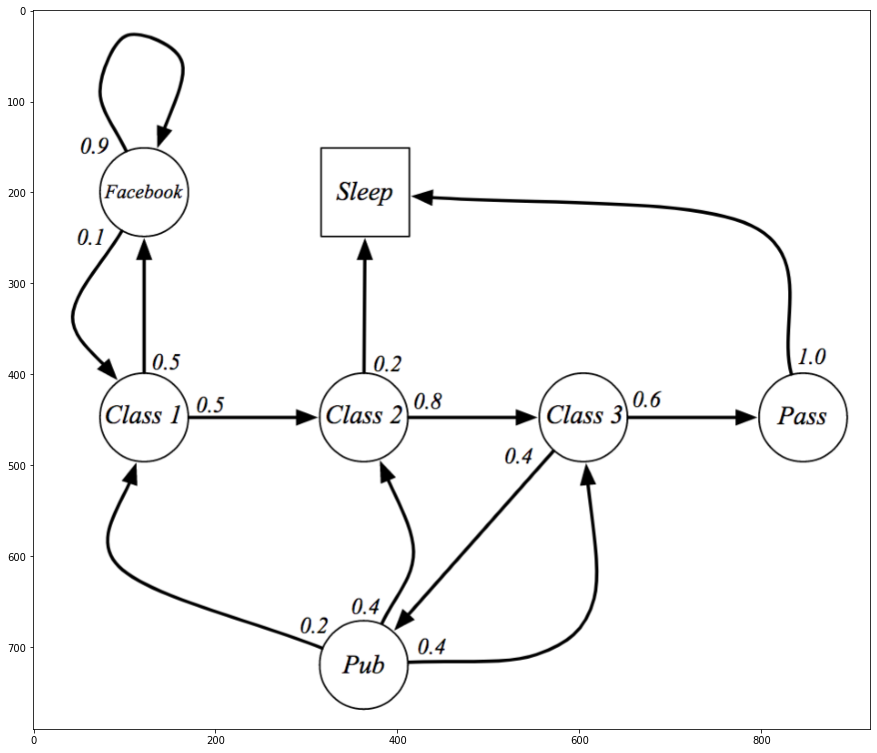

In [4]:
img = mpimg.imread('/Users/sven/Downloads/david_silver_mdp.png')
plt.figure(figsize=(15,15))
plt.imshow(img)

In [36]:
from typing import (Dict, Iterable, Generic, Sequence, Tuple,
                    Mapping, Optional, TypeVar)

In [37]:
@markov_process.dataclass(frozen=True)
class DSilverState:
    name: str

DS_MapType = Dict[str, Iterable[Tuple[str, int]]] ## dictionary, str -> list of tuple
DS_StateMap = Dict[str, DSilverState]
        
DS_States: DS_StateMap = {
    "Class 1": DSilverState("Class 1"),
    "Class 2": DSilverState("Class 2"),
    "Class 3": DSilverState("Class 3"),
    "Facebook": DSilverState("Facebook"),
    "Pub": DSilverState("Pub"),
    "Pass": DSilverState("Pass"),
    "Fail": DSilverState("Fail")
}

DS_Transition_Map: DS_MapType = {
    "Class 1": [('Facebook', 0.5),  ("Class 2", 0.5)],
    "Class 2": [('Pub', 0.2), ("Class 3", 0.8)],
    "Class 3": [('Pass', 0.6),  ("Pub", 0.4)],
    "Facebook": [('Facebook', 0.7), ('Fail', 0.2),  ("Class 1", 0.1)],
    "Pub": [("Class 1", 0.2),  ("Class 2", 0.3), ("Class 3", 0.4), ("Fail", 0.1)],
    "Pass": [],
    "Fail": []
}

In [38]:
class DSilverMDP(markov_process.FiniteMarkovProcess[DSilverState]):

    def __init__(self, ds_map: DS_MapType, ds_states: DS_StateMap):
        self.ds_states = ds_states
        self.ds_map = ds_map
        super().__init__(self.get_transition_map())

    def get_transition_map(self) -> markov_process.Transition[DSilverState]:
        d: Dict[InventoryState, Categorical[InventoryState]] = {}
        for name, state in self.ds_states.items():
            if len(DS_Transition_Map[name]) == 0:
                d[state] = None
            else:
                state_probs_map: Mapping[DSilverState, float] = {
                    self.ds_states[next_state_name]: prob for next_state_name, prob in self.ds_map[name]
                }
                d[state] = distribution.Categorical(state_probs_map)
        return d


In [39]:
mdp = DSilverMDP(DS_Transition_Map, DS_States)

In [44]:
mdp.transition_map[DSilverState("Class 1")]

{DSilverState(name='Facebook'): 0.5, DSilverState(name='Class 2'): 0.5}

In [34]:
mdp.transition_map == mdp.get_transition_map()

True

In [24]:
mdp.get_transition_map()

{DSilverState(name='Class 1'): {DSilverState(name='Facebook'): 0.5, DSilverState(name='Class 2'): 0.5},
 DSilverState(name='Class 2'): {DSilverState(name='Pub'): 0.2, DSilverState(name='Class 3'): 0.8},
 DSilverState(name='Class 3'): {DSilverState(name='Pass'): 0.6, DSilverState(name='Pub'): 0.4},
 DSilverState(name='Facebook'): {DSilverState(name='Facebook'): 0.7000000000000001, DSilverState(name='Fail'): 0.20000000000000004, DSilverState(name='Class 1'): 0.10000000000000002},
 DSilverState(name='Pub'): {DSilverState(name='Class 1'): 0.2, DSilverState(name='Class 2'): 0.3, DSilverState(name='Class 3'): 0.4, DSilverState(name='Fail'): 0.1},
 DSilverState(name='Pass'): None,
 DSilverState(name='Fail'): None}

In [35]:
print(mdp)

From State DSilverState(name='Class 1'):
  To State DSilverState(name='Facebook') with Probability 0.500
  To State DSilverState(name='Class 2') with Probability 0.500
From State DSilverState(name='Class 2'):
  To State DSilverState(name='Pub') with Probability 0.200
  To State DSilverState(name='Class 3') with Probability 0.800
From State DSilverState(name='Class 3'):
  To State DSilverState(name='Pass') with Probability 0.600
  To State DSilverState(name='Pub') with Probability 0.400
From State DSilverState(name='Facebook'):
  To State DSilverState(name='Facebook') with Probability 0.700
  To State DSilverState(name='Fail') with Probability 0.200
  To State DSilverState(name='Class 1') with Probability 0.100
From State DSilverState(name='Pub'):
  To State DSilverState(name='Class 1') with Probability 0.200
  To State DSilverState(name='Class 2') with Probability 0.300
  To State DSilverState(name='Class 3') with Probability 0.400
  To State DSilverState(name='Fail') with Probability 

In [11]:
type(list(mdp.get_transition_map().keys())[0])

__main__.DSilverState

In [7]:
mdp.is_terminal(DS_States["Pass"])

True

In [8]:
start_distr = markov_process.Categorical({DS_States["Class 1"]: 0.5, DS_States["Class 2"]: 0.5})
print(type(start_distr))
for i, x in enumerate(mdp.simulate(start_distr)):
    print(x)

<class 'rl.distribution.Categorical'>
DSilverState(name='Class 2')
DSilverState(name='Class 3')
DSilverState(name='Pass')


In [9]:
class DSilverMRP(markov_process.FiniteMarkovRewardProcess[DSilverState]):
    def __init__(self, ds_map: DS_MapType, ds_states: DS_StateMap):
        self.ds_states = ds_states
        self.ds_map = ds_map
        super().__init__(self.get_transition_reward_map())

    def get_transition_reward_map(self) -> markov_process.RewardTransition[DSilverState]:
        d: Dict[DSilverState, markov_process.Categorical[Tuple[DSilverState, float]]] = {}
        for name, state in self.ds_states.items():
            if len(DS_Transition_Map[name]) == 0:
                d[state] = None
            else:
                state_probs_map: Mapping[DSilverState, float] = {}
                for next_state_name, prob in self.ds_map[name]:
                    if next_state_name == 'Pass':
                        state_probs_map[(DS_States[next_state_name], 1)] = prob 
                    else:
                        state_probs_map[(DS_States[next_state_name], 0)] = prob 
                    
                d[state] = distribution.Categorical(state_probs_map)
        return d

In [104]:
mrp = DSilverMRP(DS_Transition_Map, DS_States)

In [105]:
mrp.display_value_function(1)

{DSilverState(name='Class 3'): 0.884,
 DSilverState(name='Facebook'): 0.17,
 DSilverState(name='Pub'): 0.71,
 DSilverState(name='Class 2'): 0.849,
 DSilverState(name='Class 1'): 0.51}


In [110]:
start_distr = markov_process.Categorical({DS_States["Class 1"]: 0.5, DS_States["Class 2"]: 0.5})
print(type(start_distr))
for i, x in enumerate(mrp.simulate(start_distr)):
    print(x)

<class 'rl.distribution.Categorical'>
DSilverState(name='Class 2')
DSilverState(name='Class 3')
DSilverState(name='Pub')
DSilverState(name='Class 1')
DSilverState(name='Class 2')
DSilverState(name='Pub')
DSilverState(name='Class 2')
DSilverState(name='Pub')
DSilverState(name='Class 3')
DSilverState(name='Pub')
DSilverState(name='Class 2')
DSilverState(name='Pub')
DSilverState(name='Class 3')
DSilverState(name='Pass')


In [112]:
start_distr = markov_process.Categorical({DS_States["Class 1"]: 0.5, DS_States["Class 2"]: 0.5})
print(type(start_distr))
for i, trace in enumerate(mrp.traces(start_distr)):
    print("new trace")
    for x in enumerate(trace):
        print(x)
    if i > 10:
        break
    print()

<class 'rl.distribution.Categorical'>
new trace
(0, DSilverState(name='Class 2'))
(1, DSilverState(name='Pub'))
(2, DSilverState(name='Class 1'))
(3, DSilverState(name='Class 2'))
(4, DSilverState(name='Class 3'))
(5, DSilverState(name='Pass'))

new trace
(0, DSilverState(name='Class 1'))
(1, DSilverState(name='Facebook'))
(2, DSilverState(name='Facebook'))
(3, DSilverState(name='Facebook'))
(4, DSilverState(name='Facebook'))
(5, DSilverState(name='Facebook'))
(6, DSilverState(name='Fail'))

new trace
(0, DSilverState(name='Class 2'))
(1, DSilverState(name='Pub'))
(2, DSilverState(name='Class 3'))
(3, DSilverState(name='Pass'))

new trace
(0, DSilverState(name='Class 2'))
(1, DSilverState(name='Class 3'))
(2, DSilverState(name='Pub'))
(3, DSilverState(name='Class 2'))
(4, DSilverState(name='Class 3'))
(5, DSilverState(name='Pub'))
(6, DSilverState(name='Class 3'))
(7, DSilverState(name='Pass'))

new trace
(0, DSilverState(name='Class 2'))
(1, DSilverState(name='Class 3'))
(2, DSilverSt